In [35]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import plotter
import plot_comparison as pc
import utils
import scipy
from scipy import optimize

import nbodykit
from nbodykit.lab import cosmology

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)

In [101]:
def compare_projections_rms(projs, cat_dir, cat_tag, result_dir, rbins, seeds, labels=None, err=True, label_rmse=True):
    xmin = rbins[0]
    xmax = rbins[-1]
    
    if 'cont1000' in projs[0]:
        conttag = '_cont1000'
    r_true, xi_true, _ = np.load('{}/cf_lin_true{}{}.npy'.format(cat_dir, conttag, cat_tag), allow_pickle=True)
    r_true_binned, xi_true_binned, r_true_avg, xi_true_avg = bin_cf_single(r_true, xi_true, rbins)

    rs_mean = [None]*len(projs)
    xis_mean = [None]*len(projs)
    rs_binned_mean = [None]*len(projs)
    xis_binned_mean = [None]*len(projs)    
    rs_avg_mean = [None]*len(projs)
    xis_avg_mean = [None]*len(projs)

    if labels is None:
        labels = [None]*len(projs)
    colors = [None]*len(projs)

    error_regions = []
    error_regions_binned = []
    error_regions_avg = []

    alphas = []
    #labels = []
    
    offset = 0
    for i in range(len(projs)):
        proj = projs[i]
        print(proj)
        
        res = load_cfs(result_dir, cat_tag, proj, seeds)
        extras = None
        if len(res)>3:
            rs, xis, amps, extras = res
        else:
            rs, xis, amps = res
        if extras is not None:
            for kk in range(len(amps)):
                #print(kk, extras[kk]['alpha_result'], amps[kk])
                alphas.append(extras[kk]['alpha_result'])
                
        print("Number of boxes:", len(rs))
        rs_binned, xis_binned, rs_avg, xis_avg = bin_cfs(rs, xis, rbins)
        rs_mean[i], xis_mean[i], xis_std, xis_low, xis_high = get_mean_stats(rs, xis)

        rs_binned_mean[i], xis_binned_mean[i], xis_binned_std, xis_binned_low, xis_binned_high = get_mean_stats(rs_binned, xis_binned)
        rs_avg_mean[i], xis_avg_mean[i], xis_avg_std, xis_avg_low, xis_avg_high = get_mean_stats(rs_avg, xis_avg)

        error_regions.append([xis_low, xis_high])
        error_regions_binned.append([xis_binned_low, xis_binned_high])
        error_regions_avg.append([xis_avg_low, xis_avg_high])

        #rmserr = rmse(xis_avg_mean, xi_true_avg)
        #labels[i] = r'{}, RMSE = {:3f}'.format(proj, rmserr)
        if labels is None:
            labels[i] = utils.get_label(proj)
        colors[i] = utils.get_color(proj)

    print(np.mean(alphas), np.std(alphas))
        
    print(min(r_true), max(r_true))
    print(min(rs_mean[0]), max(rs_mean[0]))
    plotter.plot_cf_cont(rs_mean, xis_mean, r_true, xi_true, labels, colors, 
                         log=False, err=err, error_regions=error_regions, xlim=[xmin, xmax], label_rmse=label_rmse)  
    plotter.plot_cf_cont(rs_binned_mean, xis_binned_mean, r_true_binned, xi_true_binned, labels, colors, 
                         log=False, err=err, error_regions=error_regions_binned, xlim=[xmin, xmax], label_rmse=label_rmse)  
    plotter.plot_cf_cont(rs_avg_mean, xis_avg_mean, r_true_avg, xi_true_avg, labels, colors,
                         log=False, err=err, error_regions=error_regions_avg, xlim=[xmin, xmax], cont=False, label_rmse=label_rmse)  
    
    return alphas

In [4]:
def bin_cf_single(r, xi, rbins):
    xis_binned = []
    rs_binned = []
    r_avg = []
    xi_avg = []
    for i in range(len(rbins)-1):
        a = rbins[i]
        b = rbins[i+1]
        rbin, xibin = bin_average(r, xi, a, b)
        r_avg.append(np.mean(rbin))
        xi_avg.append(xibin)
        if xibin:
            for rval in rbin:
                rs_binned.append(rval)
                xis_binned.append(xibin)
    return rs_binned, xis_binned, r_avg, xi_avg

def bin_cfs(rs, xis, rbins):

    rs_binned_all = []
    xis_binned_all = []
    rs_avg_all = []
    xis_avg_all = []
    for i in range(len(xis)):
        r = rs[i]
        xi = xis[i]
        rs_binned, xis_binned, r_avg, xi_avg = bin_cf_single(r, xi, rbins)
        
        xis_binned_all.append(xis_binned)
        rs_binned_all.append(rs_binned)
        rs_avg_all.append(r_avg)
        xis_avg_all.append(xi_avg)

    return np.array(rs_binned_all), np.array(xis_binned_all), np.array(rs_avg_all), np.array(xis_avg_all)

In [5]:
def bin_average(r, x, a, b):
    xint = [x[i] for i in range(len(r)) if r[i]<b and r[i]>=a]
    rint = [r[i] for i in range(len(r)) if r[i]<b and r[i]>=a]
    return rint, np.mean(xint)

In [102]:
def load_cfs(result_dir, cat_tag, proj, seeds):
    rs = []
    xis = []
    amps = []
    extras = []
    return_extras = False
    for i in range(len(seeds)):
        tag = cat_tag+'_seed{}'.format(seeds[i])
        fn = '{}/cf_lin_{}{}.npy'.format(result_dir, proj, tag)
        if os.path.isfile(fn):
            
            res = np.load(fn, allow_pickle=True, encoding='latin1')
            if len(res)>4:
                r, xi, amp, _, extra_dict = res
                return_extras = True
            elif len(res)==4:
                r, xi, amp, _ = res
            else:
                r, xi, amp = res
        else:
            continue
        rs.append(r)
        xis.append(xi)
        amps.append(amp)
        if return_extras:
            extras.append(extra_dict)
    rs = np.array(rs)
    xis = np.array(xis)
    amps = np.array(amps)
    if return_extras:
        extras = np.array(extras)
        return rs, xis, amps, extras
    else:
        return rs, xis, amps

In [7]:
def get_mean_stats(rs, xis):
    rs_mean = np.mean(rs, axis=0)
    xis_mean = np.mean(xis, axis=0)
    xis_std = np.std(xis, axis=0)
    xis_low = xis_mean - xis_std 
    xis_high = xis_mean + xis_std 
    return rs_mean, xis_mean, xis_std, xis_low, xis_high

tophat_n44_cont1000
Number of boxes: 100
baoiter_niter6
Number of boxes: 100
0.9970894837077185 0.05959172627531413
1.0 150.0
1.0 150.0
rmse: True
plotting
Landy-Szalay/Tophat RMSE: 4.51e-04
rmse: True
plotting
rmse: True
plotting


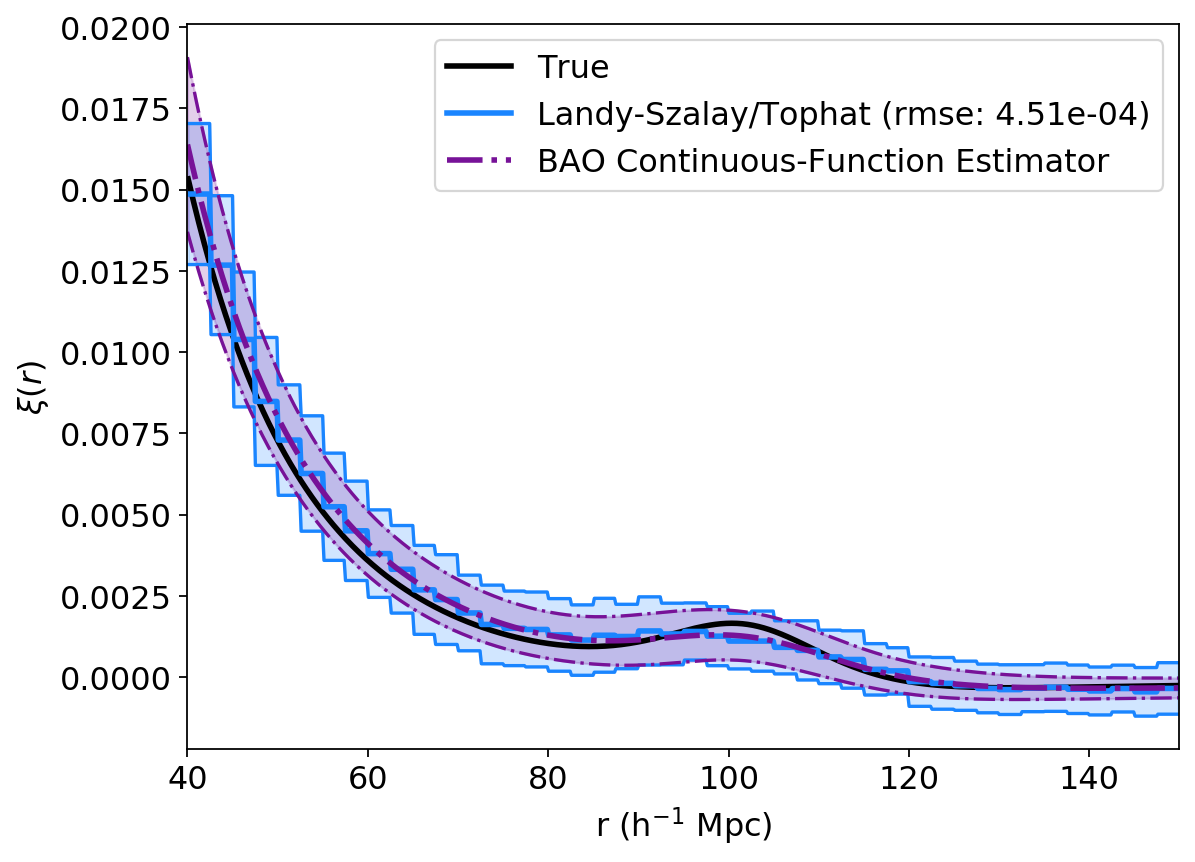

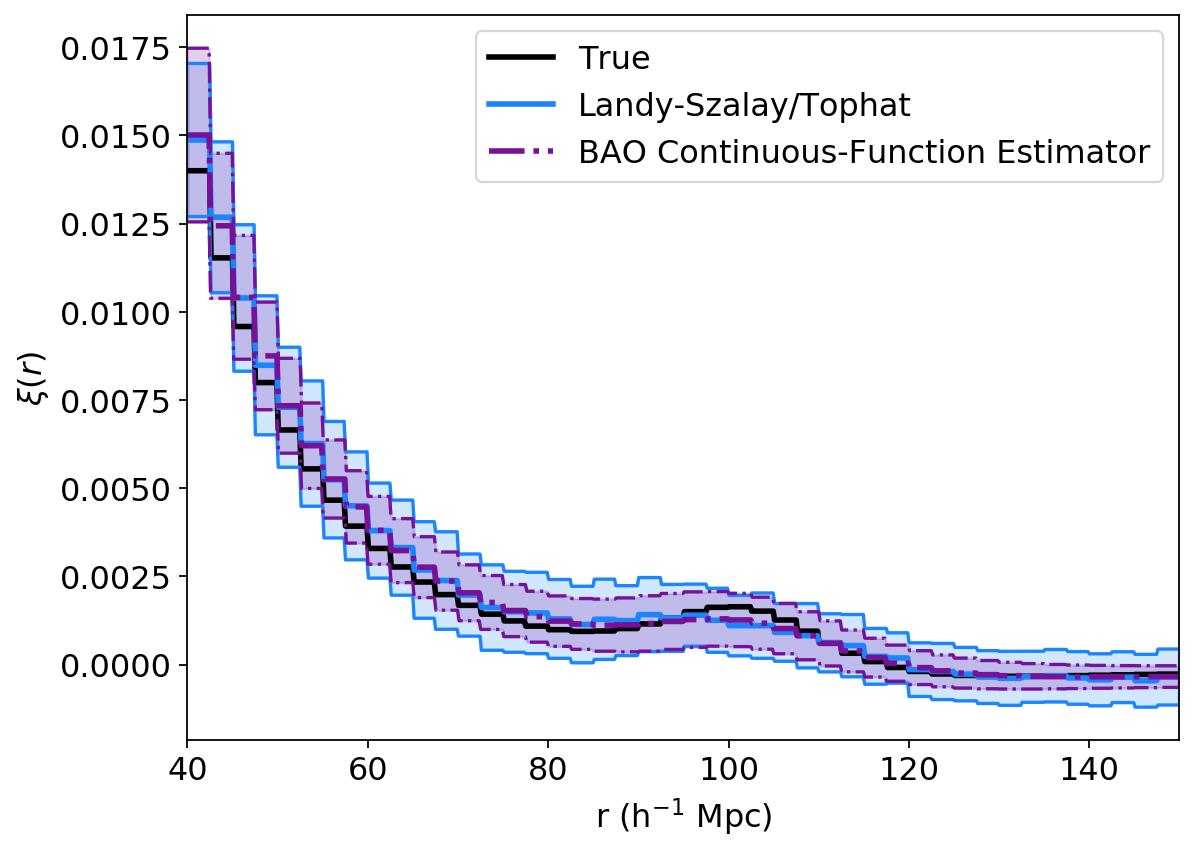

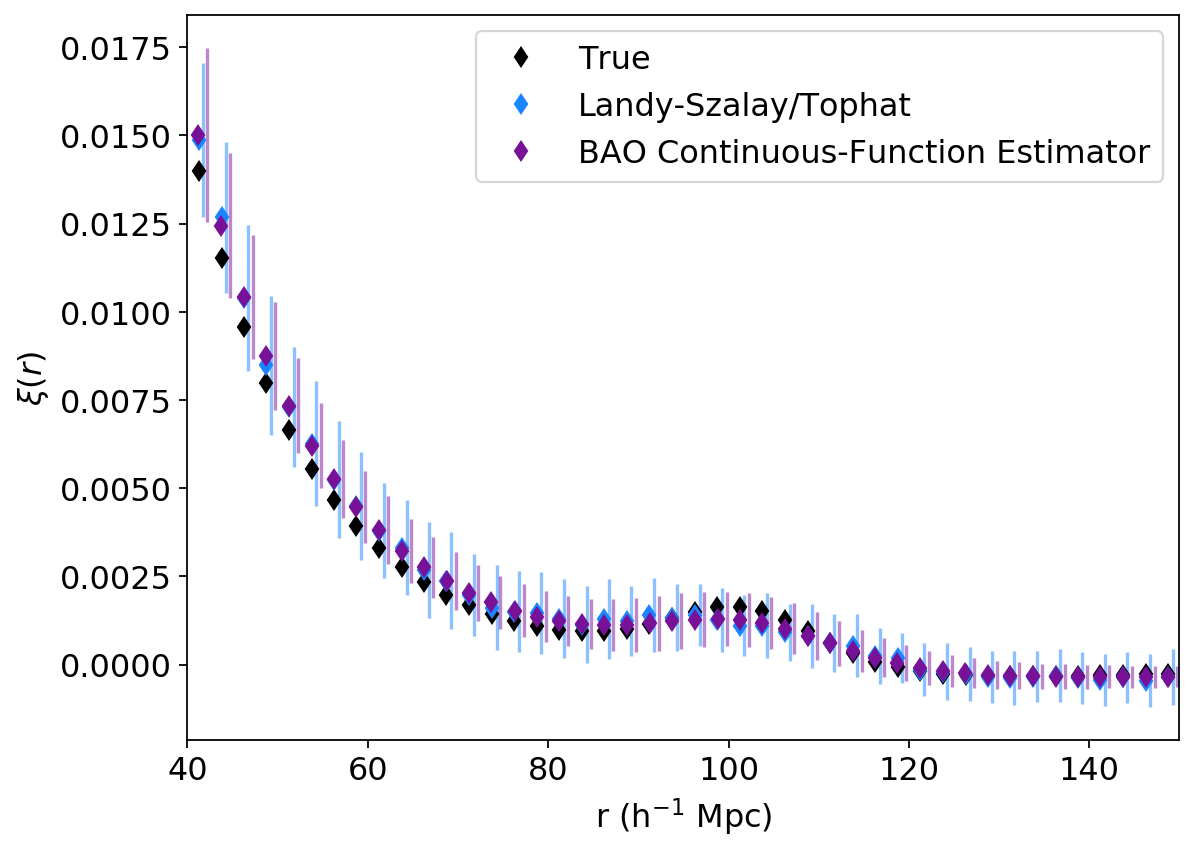

In [18]:
boxsize = 750
nbar_str = '3e-4'
cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
#N = 5
N = 100
#seeds = [98]
seeds = range(0,N)
#seeds = range(50,54) #20 and 21 bad
#seeds = range(1,19)
#seeds = range(1,7)
#seeds = [3]
result_dir = '../results/results_lognormal{}'.format(cat_tag)
cat_dir = '../catalogs/cats_lognormal{}'.format(cat_tag)

#projs = ['baoiter_niter0']
#labels=['BAO Continuous-Function Estimator']
#projs = ['tophat_n44_cont1000']
#labels=['Landy-Szalay/Tophat']

projs = ['tophat_n44_cont1000','baoiter_niter6']#,'cubic_n11_cont1000']
#projs = ['tophat_n44', 'baoiter_niter1']
labels = ['Landy-Szalay/Tophat','BAO Continuous-Function Estimator']
#projs = ['tophat', 'quadratic_n10']

#projs = ['tophat_n44', 'cubic_n11_cont1000']
#labels = ['Cubic']

#labels=None

rmin = 40
rmax = 150
nbins = 44
rbins = np.linspace(rmin, rmax, nbins+1)
#rbins_avg = 0.5*(rbins[1:]+rbins[:-1])

alphas = compare_projections_rms(projs, cat_dir, cat_tag, result_dir, rbins, seeds, labels=labels, err=False, label_rmse=True)

(array([ 3.,  0.,  3., 10., 22., 20., 20.,  8.,  5.,  6.,  2.,  0.,  0.,
         0.,  1.]),
 array([0.84058059, 0.8674743 , 0.89436802, 0.92126173, 0.94815545,
        0.97504916, 1.00194288, 1.0288366 , 1.05573031, 1.08262403,
        1.10951774, 1.13641146, 1.16330517, 1.19019889, 1.21709261,
        1.24398632]),
 <a list of 1 Patch objects>)

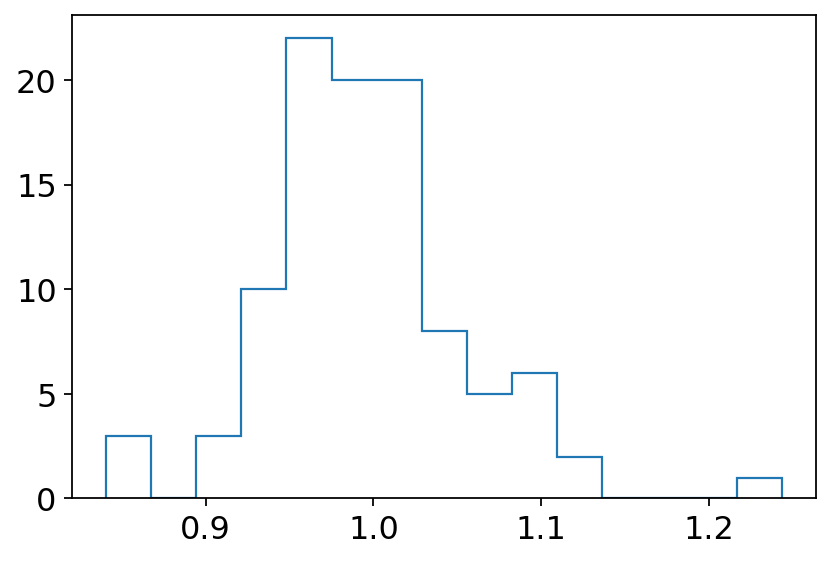

In [9]:
plt.hist(alphas, bins=15, histtype='step')

In [22]:
def load_cf(directory, cat_tag, proj, seed=None):
    if 'true' in proj:
        data = np.load('{}/cf_lin_true{}.npy'.format(directory, cat_tag), allow_pickle=True, encoding='latin1')
        r, xi, _ = data
        return r, xi
    elif 'standard' in proj:
        tag = cat_tag+'_seed{}'.format(seed)
        data = np.load('{}/cf_lin_{}{}.npy'.format(directory, proj, tag), allow_pickle=True, encoding='latin1')
        r, xi, _ = data
        return r, xi
    else:    
        tag = cat_tag+'_seed{}'.format(seed)
        data = np.load('{}/cf_lin_{}{}.npy'.format(directory, proj, tag), allow_pickle=True, encoding='latin1')
        r, xi, amp, _ = data
        return r, xi, amp

22


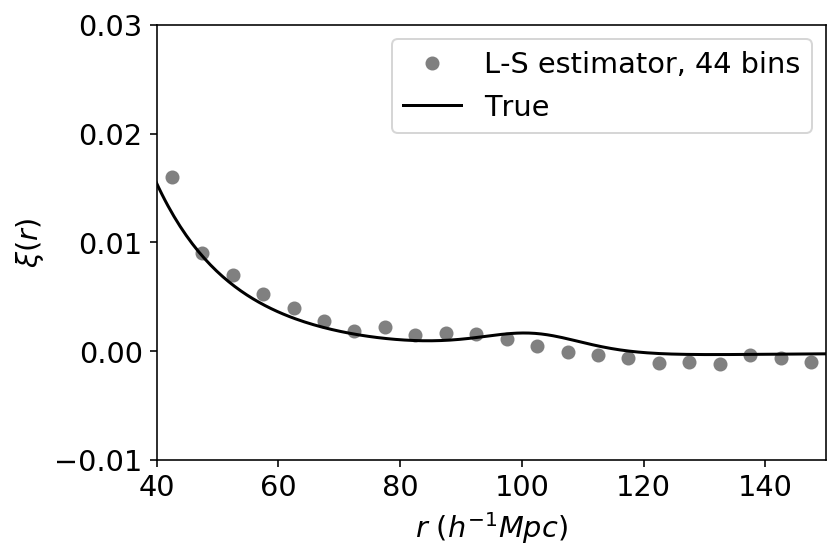

In [84]:
smin = 40
smax = 150
boxsize = 750
nbar_str = '3e-4'
cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
result_dir = '../results/results_lognormal{}'.format(cat_tag)
cat_dir = '../catalogs/cats_lognormal{}'.format(cat_tag)

s_samp, xi_samp = load_cf(result_dir, cat_tag, 'standard', seed=0)
s_true, xi_true = load_cf(cat_dir, cat_tag, 'true')


print(len(xi_samp))
plt.plot(s_samp, xi_samp, marker='o', ls='None', color='grey', label='L-S estimator, 44 bins')
plt.plot(s_true, xi_true, color='k', label='True')
plt.xlabel(r'$r$ $(h^{-1}Mpc)$')
plt.ylabel(r'$\xi(r)$')
plt.xlim(smin, smax)
plt.ylim(-0.01, 0.03)
plt.legend()

In [184]:
boxsize = 750
nbar_str = '3e-4'
cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
#N = 5
N = 100
#seeds = [98]
seeds = range(0,N)

proj = 'tophat_n44_cont1000'

res = load_cfs(result_dir, cat_tag, proj, seeds)
rs, xis, amps = res

print("Number of boxes:", len(rs))
rs_binned, xis_binned, rs_avg, xis_avg = bin_cfs(rs, xis, rbins)

alphas_baoiter = []
proj = 'baoiter_niter3'
res = load_cfs(result_dir, cat_tag, proj, seeds)
rs_baoiter, xis_baoiter, amps_baoiter, extras = res
for kk in range(len(amps)):
    alphas_baoiter.append(extras[kk]['alpha_result'])
        

Number of boxes: 100


In [185]:
print(np.mean(alphas_baoiter))

0.9953134552558766


In [85]:
base_names = [r'$a_1$', r'$a_2$', r'$a_3$', r'$B^2$', '$C$']
base_colors = ['magenta', 'red', 'orange', 'green', 'blue']

In [132]:
def fit(s_samp, xi_samp, alpha_model):
    redshift = 0
    cosmo_base = nbodykit.cosmology.Planck15
    Plin = cosmology.LinearPower(cosmo_base, redshift, transfer='EisensteinHu')
    CF = cosmology.correlation.CorrelationFunction(Plin)
    
    #def cf_model(s, alpha_model):
    #    return CF(alpha_model*s)
    
    
    def bao_bases(s, CF, alpha_model):
        b1 = 1.0/s**2
        b2 = 0.1/s
        b3 = 0.001*np.ones(len(s))

        #cf = cf_func(s, alpha_model=alpha_model)
        cf = CF(s*alpha_model)
        b4 = cf
        return b1,b2,b3,b4
    
    def xi_fit(s, a1, a2, a3, Bsq):#, cf_func, alpha_model):
        b1,b2,b3,b4 = bao_bases(s, CF, alpha_model)
        return a1*b1 + a2*b2 + a3*b3 + Bsq*b4
    
    guess = np.ones(4)
    #args = (cf_model, alpha_model)
    popt, pcov = scipy.optimize.curve_fit(xi_fit, s_samp, xi_samp, p0=guess)#, args=args)
    #for i in range(len(popt)):
    #    print('{}: {:.4f}'.format(base_names[i], popt[i]))
        
    #xerror = np.diag(np.ones(len(xi_samp)))
    xerror = np.ones(len(xi_samp))
    chi_squared = np.sum(((xi_fit(s_samp, *popt) - xi_samp) / xerror) ** 2)
    reduced_chi_squared = chi_squared / (len(s_samp) - len(popt))
    #print('The degrees of freedom for this test is', len(s_samp) - len(popt) )
    #print('The chi squared value is: ', ("%.2e" % chi_squared) )
    #print('The reduced chi squared value is: ', ("%.2e" % reduced_chi_squared) )
    
    xi_myfit = xi_fit(s_true, *popt)
    
    return popt, xi_myfit, chi_squared

In [167]:
alphas_best = []
xis_best = []
alphas_baoiter_subset = []

alphas_model = np.linspace(0.8, 1.2, 41)
print(alphas_model)


for i in range(100):
    
    chis = []
    fits = []
    for alpha_model in alphas_model:
        popt, xi_myfit, chi_squared = fit(rs_avg[i], xis_avg[i], alpha_model)
        chis.append(chi_squared)
        fits.append(xi_myfit)
    #print(alphas_model)
    #print(chis)
    
    imin = np.argmin(chis)
    print(alphas_model[imin], chis[imin])
    print(alphas_baoiter[i])
    
    alphas_best.append(alphas_model[imin])
    xis_best.append(fits[imin])
    alphas_baoiter_subset.append(alphas_baoiter[i])

print(np.mean(alphas_best), np.std(alphas_best))
print(np.mean(alphas_baoiter_subset), np.std(alphas_baoiter_subset))

[0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93
 0.94 0.95 0.96 0.97 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07
 1.08 1.09 1.1  1.11 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2 ]
1.09 2.094614297149061e-05
1.058087208890614
0.8 2.1416139783631826e-05
1.09408236261578
0.98 3.1905840396286016e-05
0.959576726101128
1.0 1.8619370565567932e-05
0.9770481782199576
1.05 1.846391793173451e-05
1.0259068712351742
0.97 1.626194316201369e-05
0.97454099241389
0.9400000000000001 1.76624872999443e-05
0.9313705913461416
0.96 2.0827823408897177e-05
0.9554500256580458
1.06 1.6109413305261222e-05
1.0614296599108866
0.97 1.263111270229338e-05
0.957463651660461
1.01 1.5520768817225012e-05
0.9893047750833751
1.05 2.6508243840859055e-05
0.990722492624513
1.0 2.096446358557457e-05
0.9584047750171926
1.1099999999999999 2.005850958594884e-05
0.8600139361040402
0.99 1.6255112562546e-05
0.997738675050508
1.0 1.305148960325094e-05
0.9898261480821342
1.0 2.327363367163253e-05
1.04431371

KeyboardInterrupt: 

0.9400000000000001
1.058087208890614
22


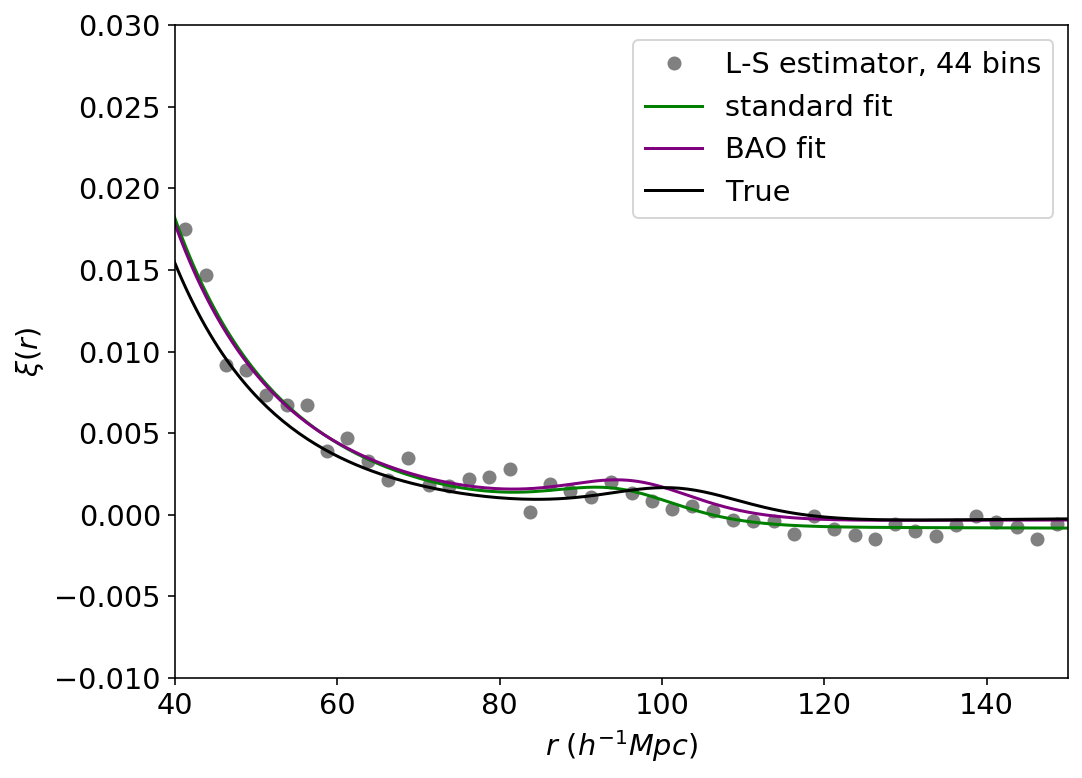

In [136]:
smin = 40
smax = 150
boxsize = 750
nbar_str = '3e-4'
cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
result_dir = '../results/results_lognormal{}'.format(cat_tag)
cat_dir = '../catalogs/cats_lognormal{}'.format(cat_tag)

s_samp, xi_samp = load_cf(result_dir, cat_tag, 'standard', seed=0)
s_true, xi_true = load_cf(cat_dir, cat_tag, 'true')

i = 0
print(alphas_best[i])
print(alphas_baoiter_subset[i])

print(len(xi_samp))
plt.figure(figsize=(8,6))
plt.plot(rs_avg[i], xis_avg[i], marker='o', ls='None', color='grey', label='L-S estimator, 44 bins')

plt.plot(s_true, xis_best[i], color='green', label='standard fit')

plt.plot(rs_baoiter[i], xis_baoiter[i], color='purple', label='BAO fit')

plt.plot(s_true, xi_true, color='k', label='True')
plt.xlabel(r'$r$ $(h^{-1}Mpc)$')
plt.ylabel(r'$\xi(r)$')
plt.xlim(smin, smax)
plt.ylim(-0.01, 0.03)
plt.legend()

0.96
0.957463651660461


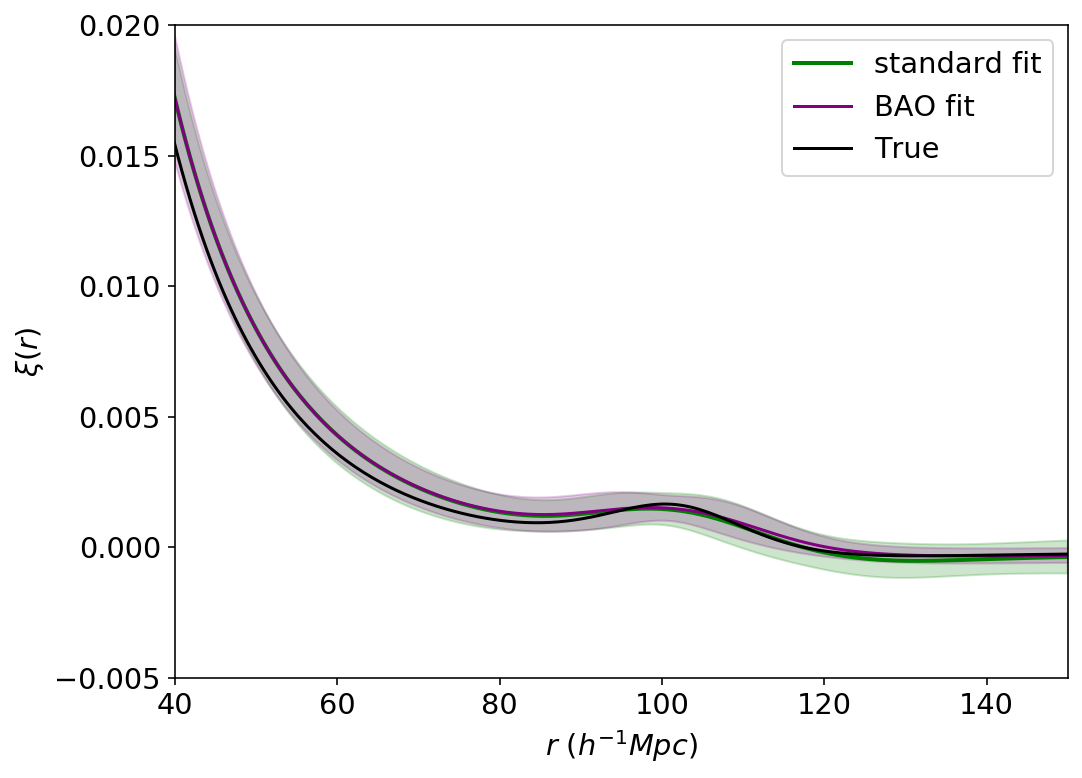

In [166]:
smin = 40
smax = 150
boxsize = 750
nbar_str = '3e-4'
cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
result_dir = '../results/results_lognormal{}'.format(cat_tag)
cat_dir = '../catalogs/cats_lognormal{}'.format(cat_tag)

s_samp, xi_samp = load_cf(result_dir, cat_tag, 'standard', seed=0)
s_true, xi_true = load_cf(cat_dir, cat_tag, 'true')

print(alphas_best[i])
print(alphas_baoiter_subset[i])

plt.figure(figsize=(8,6))
#plt.plot(rs_avg[i], xis_avg[i], marker='o', ls='None', color='grey', label='L-S estimator, 44 bins')

xis_best_mean = np.mean(xis_best, axis=0)
xis_best_std = np.std(xis_best, axis=0)
plt.plot(s_true, xis_best_mean, color='green', label='standard fit', lw=2)
plt.fill_between(s_true, xis_best_mean-xis_best_std, xis_best_mean+xis_best_std, alpha=0.2, color='green')

NN = 10
rs_baoiter_mean = np.mean(rs_baoiter[:NN], axis=0)
xis_baoiter_mean = np.mean(xis_baoiter[:NN], axis=0)
xis_baoiter_std = np.std(xis_baoiter[:NN], axis=0)

plt.plot(rs_baoiter_mean, xis_baoiter_mean, color='purple', label='BAO fit')
plt.fill_between(rs_baoiter_mean, xis_baoiter_mean-xis_baoiter_std, xis_baoiter_mean+xis_baoiter_std, alpha=0.2, color='purple')

plt.plot(s_true, xi_true, color='k', label='True')
plt.xlabel(r'$r$ $(h^{-1}Mpc)$')
plt.ylabel(r'$\xi(r)$')
plt.xlim(smin, smax)
plt.ylim(-0.005, 0.02)
plt.legend()

(2,)
rmse: False
plotting
a RMSE: nan


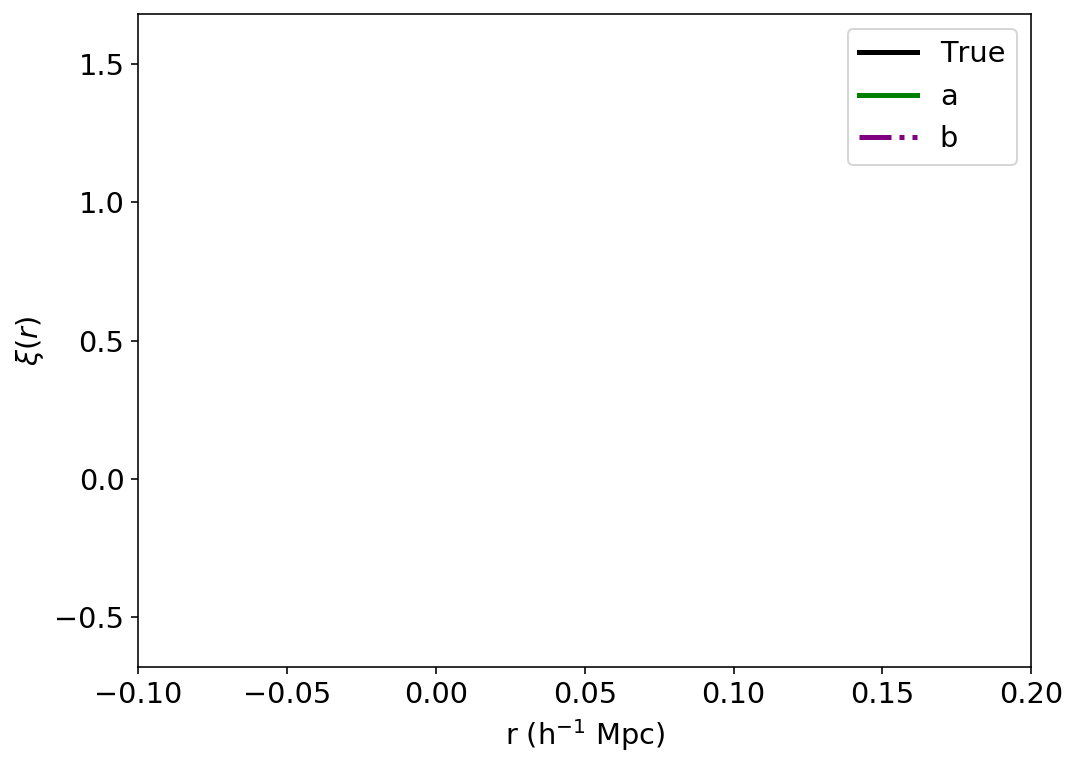

In [164]:
rs_mean = [s_true, rs_baoiter_mean]
xis_mean = [xis_best_mean, xis_baoiter_mean]
error_regions = [[xis_best_mean-xis_best_std, xis_best_mean+xis_best_std],
                [xis_baoiter_mean-xis_baoiter_std, xis_baoiter_mean+xis_baoiter_std]]
labels = ['a', 'b']
colors = ['green', 'purple']
label_rmse = False
err = False
xlim = [-0.1, 0.2]
plotter.plot_cf_cont(rs_mean, xis_mean, s_true, xi_true, labels, colors, 
                         log=False, err=err, error_regions=error_regions, xlim=xlim, label_rmse=label_rmse) 

0.9994040000000001 0.07573288839071173


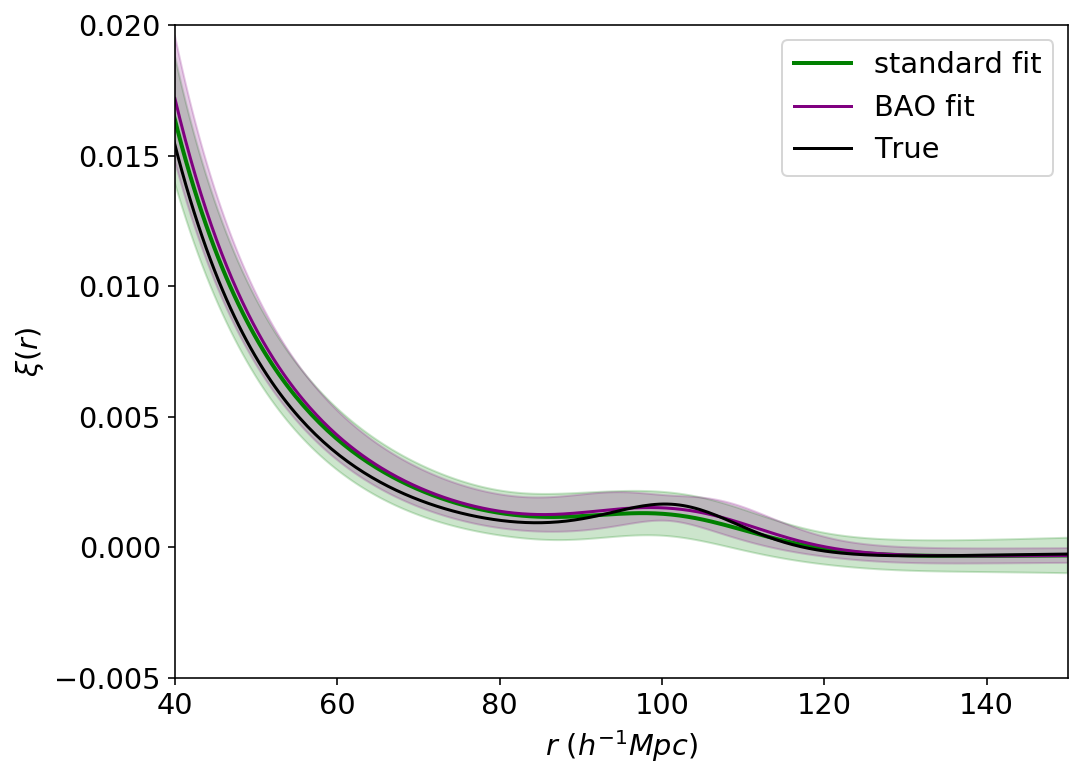

In [178]:
smin = 40
smax = 150
boxsize = 750
nbar_str = '3e-4'
cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
result_dir = '../results/results_lognormal{}'.format(cat_tag)
cat_dir = '../catalogs/cats_lognormal{}'.format(cat_tag)
tag = ''

save_fn = '{}/bao_standard{}{}.npy'.format(result_dir, cat_tag, tag)
bao_standard = np.load(save_fn, allow_pickle=True)

s_true, xis_best, alphas_best, popts_best, seeds, alpha_model = bao_standard
alphas_best_corr = np.array(alphas_best)*alpha_model
print(np.mean(alphas_best_corr), np.std(alphas_best_corr))

s_true, xi_true = load_cf(cat_dir, cat_tag, 'true')

plt.figure(figsize=(8,6))
#plt.plot(rs_avg[i], xis_avg[i], marker='o', ls='None', color='grey', label='L-S estimator, 44 bins')

xis_best_mean = np.mean(xis_best, axis=0)
xis_best_std = np.std(xis_best, axis=0)
plt.plot(s_true, xis_best_mean, color='green', label='standard fit', lw=2)
plt.fill_between(s_true, xis_best_mean-xis_best_std, xis_best_mean+xis_best_std, alpha=0.2, color='green')

NN = 10
rs_baoiter_mean = np.mean(rs_baoiter[:NN], axis=0)
xis_baoiter_mean = np.mean(xis_baoiter[:NN], axis=0)
xis_baoiter_std = np.std(xis_baoiter[:NN], axis=0)

plt.plot(rs_baoiter_mean, xis_baoiter_mean, color='purple', label='BAO fit')
plt.fill_between(rs_baoiter_mean, xis_baoiter_mean-xis_baoiter_std, xis_baoiter_mean+xis_baoiter_std, alpha=0.2, color='purple')

plt.plot(s_true, xi_true, color='k', label='True')
plt.xlabel(r'$r$ $(h^{-1}Mpc)$')
plt.ylabel(r'$\xi(r)$')
plt.xlim(smin, smax)
plt.ylim(-0.005, 0.02)
plt.legend()